In [1]:
import numpy as np 
import pandas as pd 
import splitfolders
import os

In [2]:
train_dire='/kaggle/input/plant-seedlings-classification/train'
seed=0

In [3]:
# spliting the data into train & test folders
splitfolders.ratio(train_dire, output="output",
    seed=42, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 4750 files [00:37, 126.29 files/s]


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

number of training examples original:


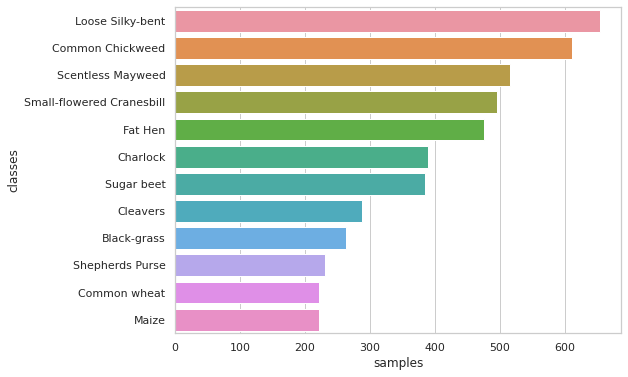

In [5]:
print('number of training examples original:')
class_names=[]
examples=[]
for i in os.listdir(train_dire):
    j=os.path.join(train_dire,i)
    class_names.append(i)
    examples.append(len(os.listdir(j)))

df = pd.DataFrame(list(zip(class_names,examples)), columns =['classes','samples'])

import seaborn as sns
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="samples", y="classes", data=df,orient='h',order=df.sort_values('samples',ascending=False).classes)

number of training examples after split:


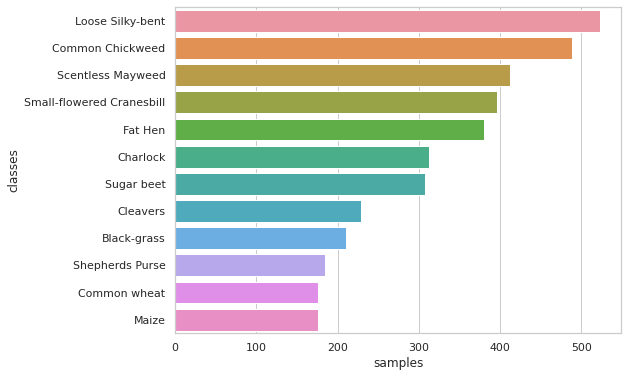

In [6]:
print('number of training examples after split:')
training_dir='/kaggle/working/output/train'
class_names=[]
examples=[]
for i in os.listdir(training_dir):
    j=os.path.join(training_dir,i)
    class_names.append(i)
    examples.append(len(os.listdir(j)))

df = pd.DataFrame(list(zip(class_names,examples)), columns =['classes','samples'])

import seaborn as sns
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="samples", y="classes", data=df,orient='h',order=df.sort_values('samples',ascending=False).classes)

number of validation examples after split:


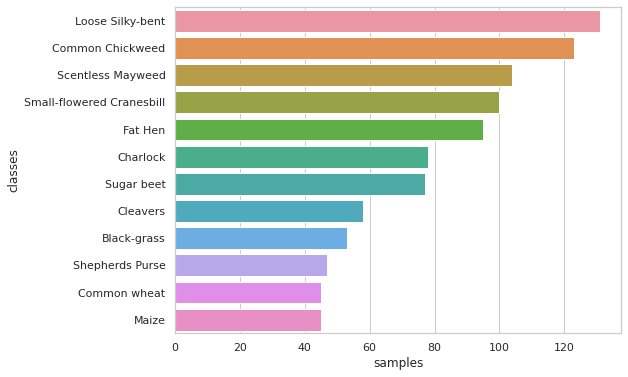

In [7]:
print("number of validation examples after split:")
val_dir='/kaggle/working/output/val'
class_names=[]
examples=[]
for i in os.listdir(val_dir):
    j=os.path.join(val_dir,i)
    class_names.append(i)
    examples.append(len(os.listdir(j)))

df = pd.DataFrame(list(zip(class_names,examples)), columns =['classes','samples'])

import seaborn as sns
sns.set_theme(style="whitegrid")
# tips = sns.load_dataset("tips")
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x="samples", y="classes", data=df,orient='h',order=df.sort_values('samples',ascending=False).classes)

In [8]:
#list of categories sorted
cat=os.listdir(val_dir)
cat.sort()

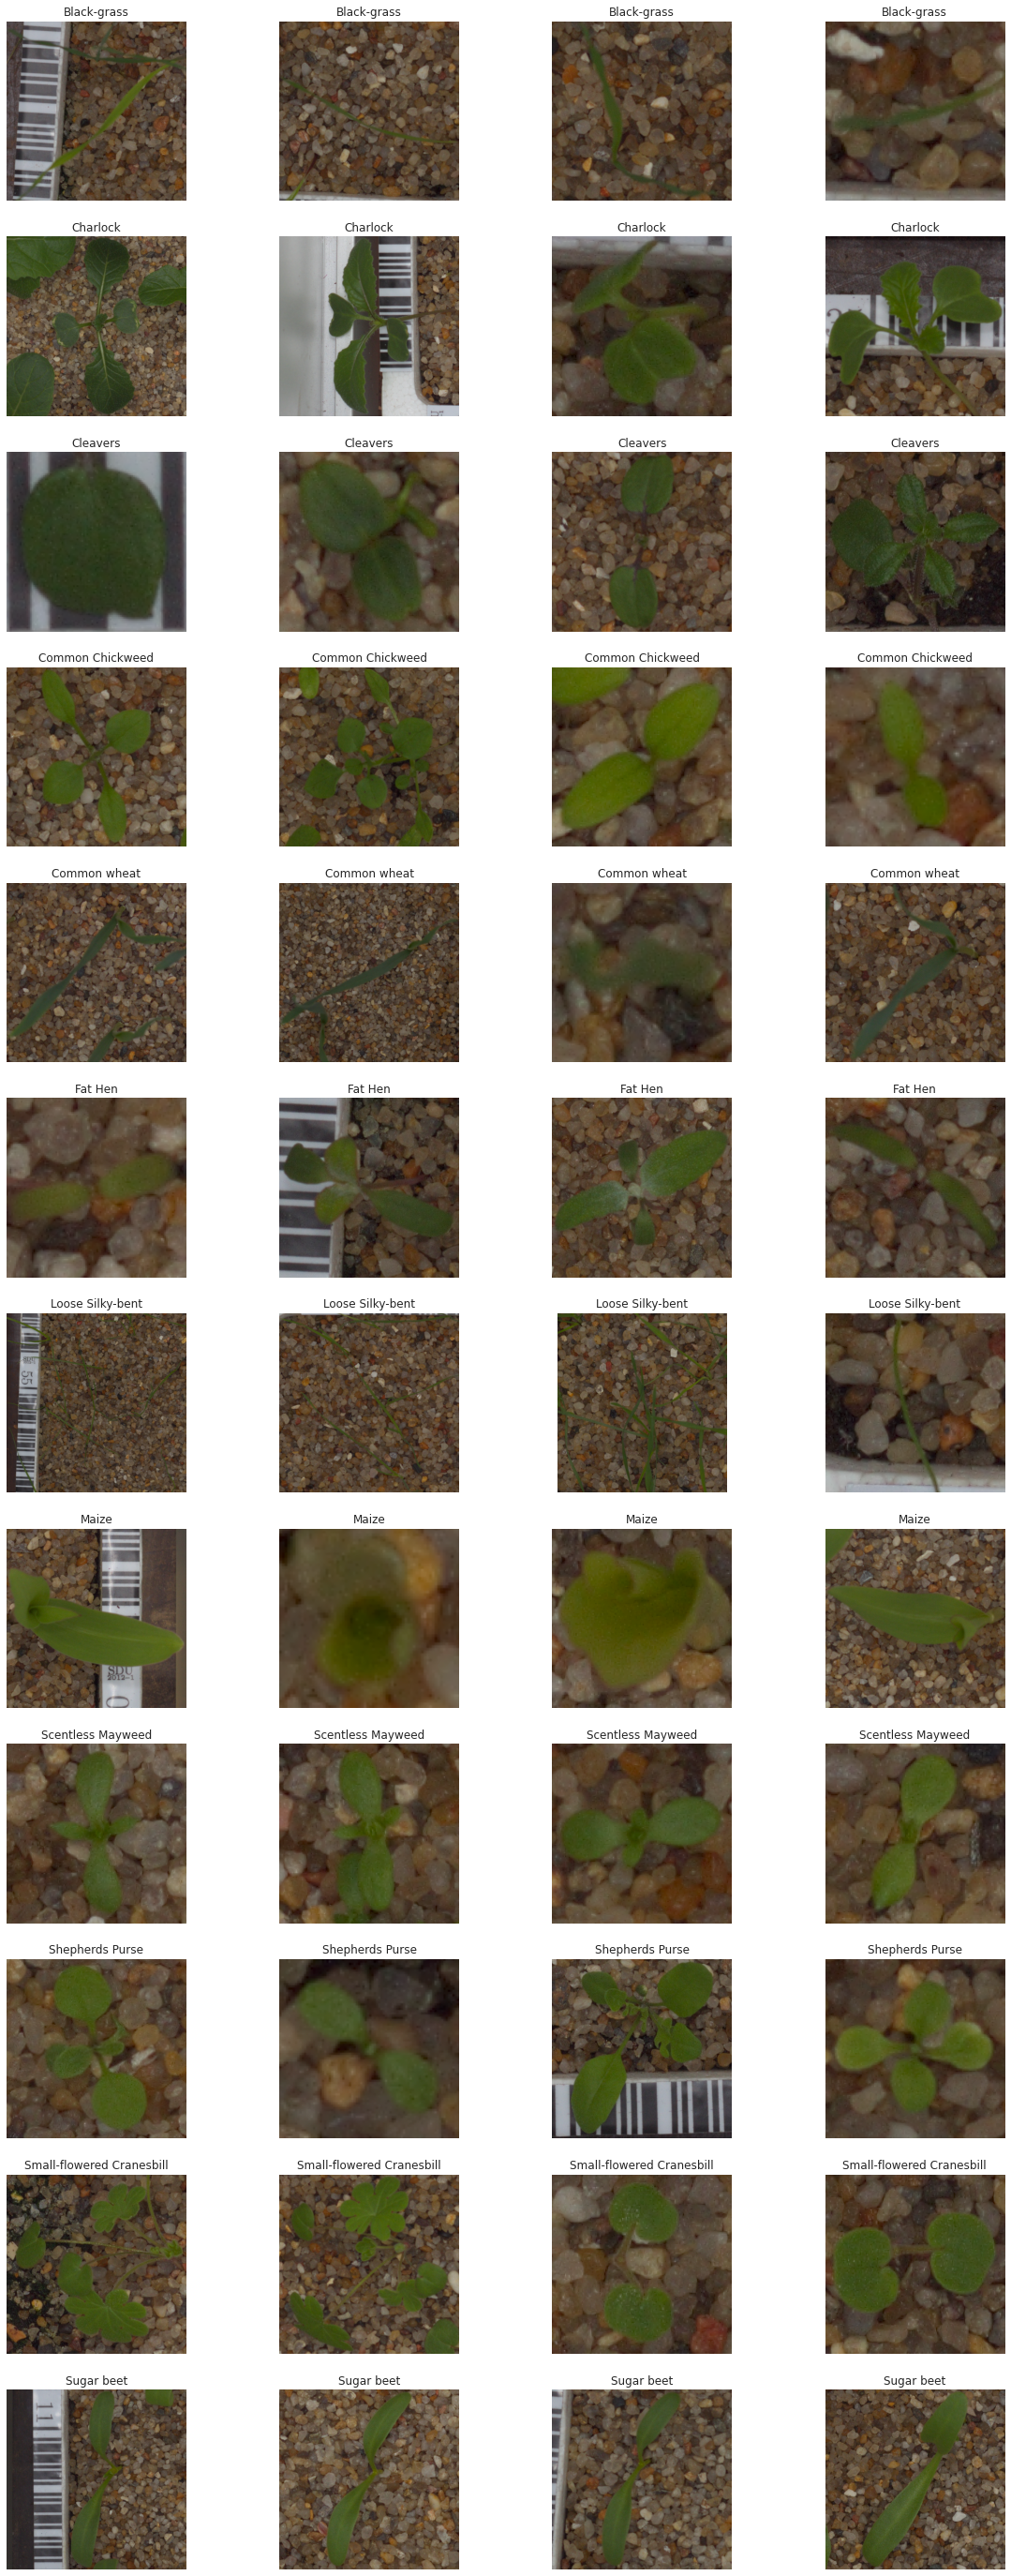

In [9]:
# see some training examples
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path_list=[]
for i in cat:
    pic_index = 4
    img_name=os.listdir(val_dir+'/'+i)[0:pic_index]
    
    img_paths = [os.path.join(val_dir+'/'+i, fname) 
                for fname in img_name]
    for k in img_paths:
        path_list.append([k,i])
        
fig = plt.figure(figsize=(20,50))
rows=12
columns=4

for i in range(rows*columns):
    fig.add_subplot(rows,columns,i+1)
    img=mpimg.imread(path_list[i][0])
    plt.title(path_list[i][1])
    plt.imshow(img)
    plt.axis('Off')

In [10]:
plant_img='/kaggle/working/output/val/Charlock/f67425c37.png'

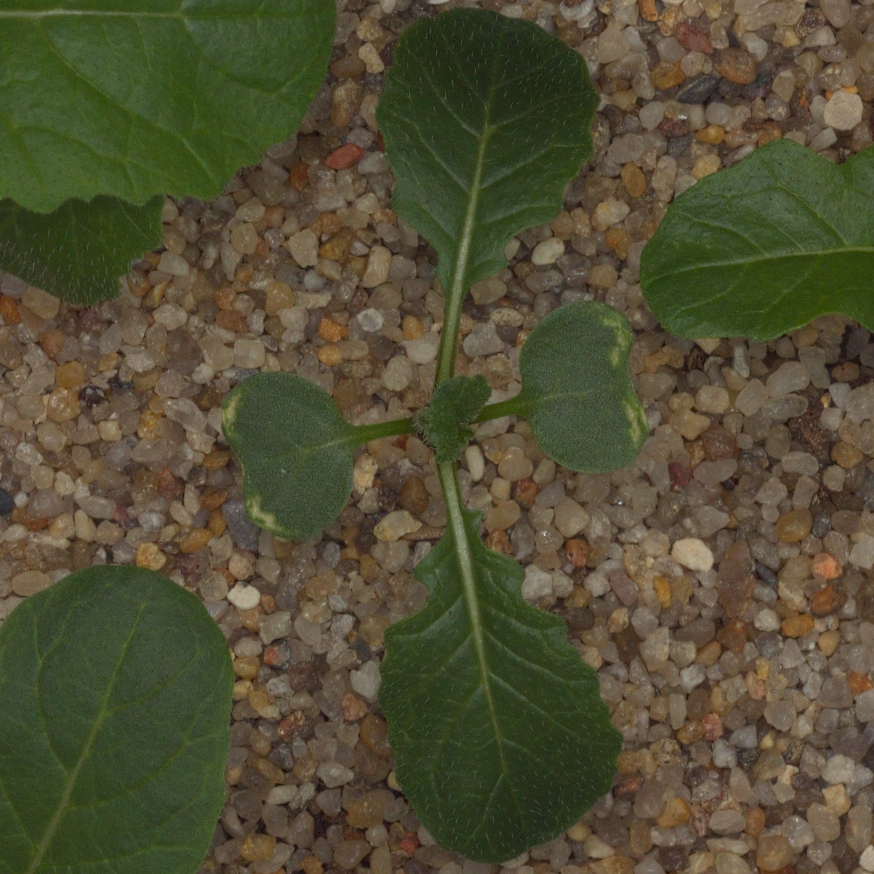

In [11]:
from PIL import Image
import requests

img= Image.open(plant_img)
img

In [12]:
from matplotlib import colors
img=np.array(img)
pixel_colours=img.reshape((img.shape [0]*img.shape[1],3))
norm=colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colours)
pixel_colours=norm(pixel_colours).tolist()

In [13]:
import cv2
hsv_img=cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
h,s,v=cv2.split(hsv_img)

<function matplotlib.pyplot.show(close=None, block=None)>

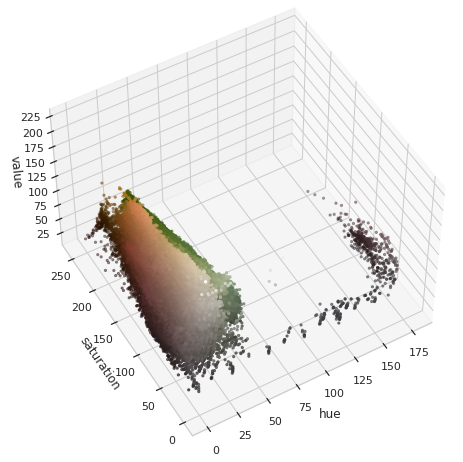

In [14]:
fig=plt.figure(figsize=(8,8))
axis=fig.add_subplot(1,1,1,projection='3d')
axis.view_init(50,240)
axis.scatter(h.flatten(),s.flatten(),v.flatten(),facecolors=pixel_colours,marker='.')
axis.set_xlabel('hue')
axis.set_ylabel('saturation')
axis.set_zlabel('value')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

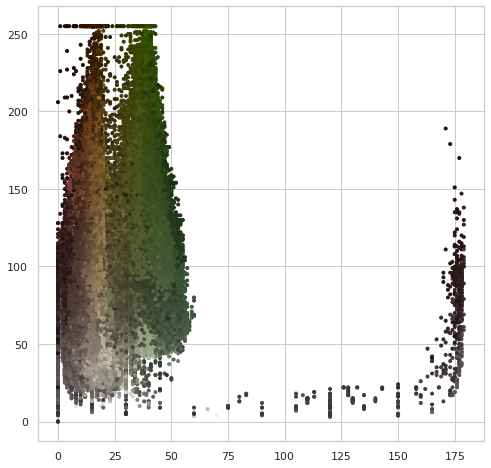

In [15]:
fig=plt.figure(figsize=(8,8))
axis=fig.add_subplot(1,1,1)

# axis.view_init(50,240)
axis.scatter(h.flatten(),s.flatten(),facecolors=pixel_colours,marker='.')
plt.show

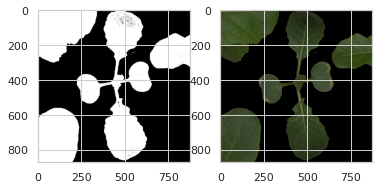

In [16]:
light_orange = (27,50,40)
dark_orange = (60,250,155 )

mask = cv2.inRange(hsv_img, light_orange, dark_orange)
result = cv2.bitwise_and(img, img, mask=mask)

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Now, we can do masking of image like this, but when I trained a model with masking it is not helping. So further in my model masking is not involved in it.

In [17]:
# create data generator object
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = '/kaggle/working/output/train'
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = '/kaggle/working/output/val'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(200,200),
	class_mode='categorical',
  batch_size=32,seed=seed
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(200,200),
	class_mode='categorical',
    batch_size=128,shuffle=False
)

Found 3794 images belonging to 12 classes.
Found 956 images belonging to 12 classes.


In [18]:
# Build the Neural Network
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Activation

model_new = Sequential()

# First hiden layer of the Neural Net
model_new.add(Conv2D(filters=16, kernel_size=(5, 5), input_shape=(200,200, 3),data_format='channels_last'))
model_new.add(Activation('relu'))
model_new.add(BatchNormalization(axis=3))
model_new.add(MaxPooling2D((2, 2)))

# Secong hidden layer of the Neural Net
model_new.add(Conv2D(filters=32, kernel_size=(5, 5)))
model_new.add(Activation('relu'))
model_new.add(BatchNormalization(axis=3))
model_new.add(MaxPooling2D((2, 2)))
model_new.add(Dropout(0.1))

# Third hidden layer of the Neural Net
model_new.add(Conv2D(filters=64, kernel_size=(5, 5)))
model_new.add(Activation('relu'))
model_new.add(BatchNormalization(axis=3))
model_new.add(MaxPooling2D((2, 2)))
model_new.add(Dropout(0.1))

model_new.add(Conv2D(filters=64, kernel_size=(5, 5)))
model_new.add(Activation('relu'))
model_new.add(BatchNormalization(axis=3))
model_new.add(MaxPooling2D((2, 2)))
model_new.add(Dropout(0.2))


model_new.add(Conv2D(filters=128,kernel_size=(5,5)))
model_new.add(Activation('relu'))
model_new.add(BatchNormalization(axis=3))
model_new.add(MaxPooling2D((2, 2),padding='same'))
model_new.add(Dropout(0.3))

model_new.add(Conv2D(filters=256,kernel_size=(5,5),padding='same'))
model_new.add(Activation('relu'))
model_new.add(BatchNormalization(axis=3))
model_new.add(MaxPooling2D((2, 2),padding='same'))
model_new.add(Dropout(0.3))



model_new.add(Flatten())

model_new.add(Dense(256, activation='relu'))
model_new.add(BatchNormalization())
model_new.add(Dropout(0.3))

model_new.add(Dense(12, activation='softmax'))

model_new.summary()

2022-09-04 11:04:47.536481: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 196, 196, 16)      1216      
_________________________________________________________________
activation (Activation)      (None, 196, 196, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 196, 196, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        12832     
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 94, 94, 32)        1

In [19]:
from keras.callbacks import ReduceLROnPlateau

# learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=6, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001,mode='max')


In [20]:

def on_epoch_end(epoch, logs={}):
    

    # Check accuracy
    check=logs.get('val_accuracy')
    if( check>0.90):

    # Stop if threshold is met
        print("\nAccuracy  is greater than 0.90 so cancelling training!")
        model.stop_training = True

import tensorflow as tf
on_epoch=tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

In [21]:
model_new.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
round(model_new.optimizer.lr.numpy(),5)

0.001

In [ ]:
# train the model
history = model_new.fit(train_generator, epochs=100, steps_per_epoch=118, validation_data = validation_generator, verbose = 1, validation_steps=7,callbacks=[learning_rate_reduction,on_epoch])

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) 

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()


In [ ]:
model.save('91_accuracy_model.h5')

In [ ]:
from IPython.display import FileLink
FileLink(r'91_accuracy_model.h5')


In [23]:
# load the model
model=tf.keras.models.load_model('/kaggle/input/model-91/91_accuracy_model.h5')

In [24]:
model.evaluate_generator(validation_generator,7)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '
2022-09-04 11:05:23.944810: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[0.23215122520923615, 0.9118303656578064]

In [25]:
yhat=model.predict_generator(validation_generator,8)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [26]:
#Confution Matrix and Classification Report
# Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
from sklearn.metrics import classification_report, confusion_matrix

y_hat = np.argmax(yhat, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_hat))
print('Classification Report')
target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(validation_generator.classes, y_hat, target_names=cat))

Confusion Matrix
[[ 18   0   0   0   0   0  35   0   0   0   0   0]
 [  0  73   2   0   0   1   0   0   0   1   1   0]
 [  1   0  56   0   1   0   0   0   0   0   0   0]
 [  0   0   0 119   0   1   0   0   2   1   0   0]
 [  3   0   0   1  40   0   0   0   0   0   0   1]
 [  1   0   1   0   2  90   0   0   0   0   1   0]
 [  6   0   0   0   0   0 124   0   1   0   0   0]
 [  0   0   0   0   0   0   0  41   0   0   1   3]
 [  2   0   2   1   0   0   0   0  97   2   0   0]
 [  0   0   0   0   0   0   0   0   1  46   0   0]
 [  0   0   1   1   0   1   0   0   0   0  97   0]
 [  0   1   1   0   0   0   0   0   1   0   0  74]]
Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.58      0.34      0.43        53
                 Charlock       0.99      0.94      0.96        78
                 Cleavers       0.89      0.97      0.93        58
         Common Chickweed       0.98      0.97      0.97       123
            

<AxesSubplot:>

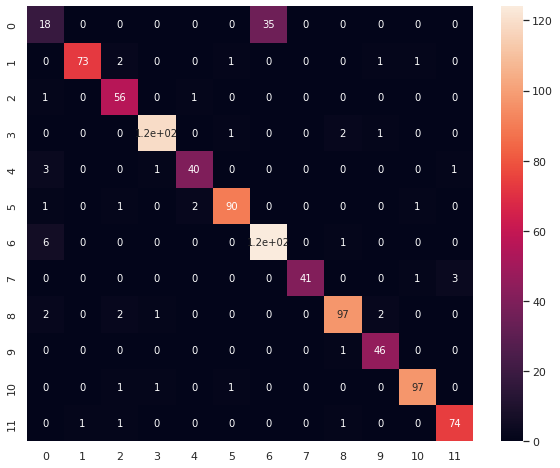

In [27]:
import seaborn as sn
cm=confusion_matrix(validation_generator.classes, y_hat)
fig = plt.figure(figsize=(10,8))
sn.heatmap(cm,annot=True)

 ## We can see that the  model is incorrectly predicting the class "0"(blck-grass) to class "6" (loose silky-bent). Lets see why ?

In [28]:
cat[0] ,cat[6]

('Black-grass', 'Loose Silky-bent')

## We can see in the images below that both of the species have very much similarity in thier shape. Shape of both the seedlings is nearly same, so it is very difficult for the model to differentiate both of this species.

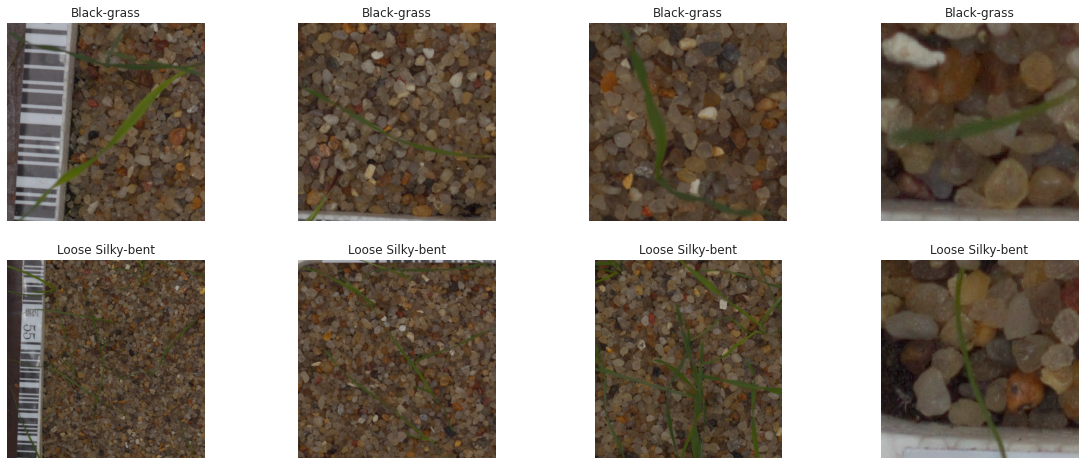

In [29]:
# see images of class "0" and class "6"
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path_list=[]
for i in ['Black-grass', 'Loose Silky-bent']:
    pic_index = 4
    img_name=os.listdir(val_dir+'/'+i)[0:pic_index]
    
    img_paths = [os.path.join(val_dir+'/'+i, fname) 
                for fname in img_name]
    for k in img_paths:
        path_list.append([k,i])
        
fig = plt.figure(figsize=(20,8))
rows=2
columns=4

for i in range(rows*columns):
    fig.add_subplot(rows,columns,i+1)
    img=mpimg.imread(path_list[i][0])
    plt.title(path_list[i][1])
    plt.imshow(img)
    plt.axis('Off')

# Testing Model On Test Dataset

In [ ]:
# import numpy as np
from keras.preprocessing import image

# predicting images
test_images=os.listdir('/kaggle/input/plant-seedlings-classification/test/')
pred_class=[]
for i in test_images:
    l='/kaggle/input/plant-seedlings-classification/test/'+i

    img=image.load_img(l, target_size=(200, 200))

    x=image.img_to_array(img)
    x /= 255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)

    pred_class.append(cat[classes.argmax()])

In [ ]:
file=test_images
species=pred_class

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(test_images,pred_class)),
                   columns =['file','species'])
df

In [ ]:
df.to_csv('submission2.csv',index=None)

In [ ]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/output/submission2.csv')